# MOVIE RECOMMENDATION SYSTEM

# 1. Defining the Question.

## a) Specifying the data analytic question.

> Ichigo is a movie company that wants to expand their horizons and make a recommender system  called MovieLens based on collaborative filtering for thousands of their clients. The recommender system aims to improve user experience by offering personalized movie recommendations catering to each user's preferences.
A better user experience, in turn, increases user satisfaction, engagement, and retention, thus increasing the profitability of the streaming platforms it serves. MovieLens has collected user ratings and movie watch history data on its platform to aid this research.




>  __Problem Statement:__ To build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.


## b) Defining the metric of success: 
> Having a model that has a low RMSE and a high recall score.

## c) Recording the Experimental Design.

- Research Question: Can a user get 5 movie recommendations based on their ratings of other movies.
- Data source: The MovieLens dataset contains 100,000 ratings, as well as demographic information and movie metadata, collected from 9,000 movies by 600 users. The dataset was collected and made available by GroupLens, a research lab at the University of Minnesota. The purpose of the dataset is to enable research in recommendation systems and related fields.The dataset can be downloaded from the GroupLens website (https://grouplens.org/datasets/movielens/latest/).
- Variables: The variables in the merged data set are:'userId', 'movieId', 'rating', 'title', 'genres', 'year'.
- Model evaluation: The metrics used to evaluate the model's performance are:accuracy,recall and RMSE.
- Conclusions and recommendations.

# 2. Loading the data

In [1]:
#Importing relevant libraries
from collections import Counter
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

In [2]:
# Loading the Datasets
movies= pd.read_csv("ml-latest-small/movies.csv")
links= pd.read_csv("ml-latest-small/links.csv")
ratings= pd.read_csv("ml-latest-small/ratings.csv")
tags= pd.read_csv("ml-latest-small/tags.csv")


In [3]:
#print the number of movies in our dataset.
print(f"Total number of movies are {movies['title'].nunique()}")

Total number of movies are 9737


# 3. Data Understanding

The MovieLens dataset contains 100,000 ratings, as well as demographic information and movie metadata, collected from  9,000 movies by 600 users. The dataset was collected and made available by GroupLens, a research lab at the University of Minnesota. The purpose of the dataset is to enable research in recommendation systems and related fields. 

The dataset can be downloaded from the GroupLens website (https://grouplens.org/datasets/movielens/latest/).

In [4]:
#check the first data set info
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
#checking for null values 
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
#checking for duplicates
movies.duplicated().sum()

0

In [7]:
#previewing the second dataset
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
#check the second data set info
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [9]:
#checking for null values in the second data set .
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [10]:
#checking for duplicates in the second data set
links.duplicated().sum()

0

In [11]:
#previewing the third dataset
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
#checking the data set info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
#checking for missing values.
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [14]:
#checking for duplicates.
ratings.duplicated().sum()

0

In [15]:
#preview the fourth dataset
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [16]:
#check data set info
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [17]:
#checking for missing values
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

# 4. External Data Source Validation

# 5. Data Preprocessing

In [18]:
#merge the data sets(movies & ratings)
#set index 
movie_ratings = pd.merge(ratings, movies, on='movieId', how = 'inner')
movie_ratings.tail()

,userId,movieId,rating,timestamp,title,genres
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller
100835,610,163981,3.5,1493850155,31 (2016),Horror


In [19]:
# Checking for Duplicates
duplicates = movie_ratings.duplicated(subset=['userId', 'movieId'])
print(duplicates.sum())

0


In [20]:
# Verifying number of Users 
print(f"Total number of users are {movie_ratings['userId'].nunique()}")

Total number of users are 610


In [21]:
# Verifying no. of Movies 
print(f"Total number of movies are {movie_ratings['title'].nunique()}")

Total number of movies are 9719


In [22]:
#Dropping the timestamp column
df= movie_ratings.drop(['timestamp'], axis=1)
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [23]:
#checking for null values in the merged data frame
df.isnull().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

In [24]:
#checking for duplicates in the merged data frame
df.duplicated().sum()

0

The merged data frame has no duplicates or missing values.

In [25]:
# Separate the Genres Column and Encoding them with One-Hot Encoding
genres = []
for i in range(len(df.genres)):
    for x in df.genres[i].split('|'):
        if x not in genres:
            genres.append(x)
            
len(genres)
for x in genres:
    df[x] = 0
for i in range(len(df.genres)):
    for x in df.genres[i].split('|'):
        df[x][i]=1
        
#dropping the genres column as it's a no longer required
df.drop(columns='genres', inplace=True)
df.sort_index(inplace=True)
#df


This code computes the total number of movies in each genre and plots a bar chart to show the popularity of each genre

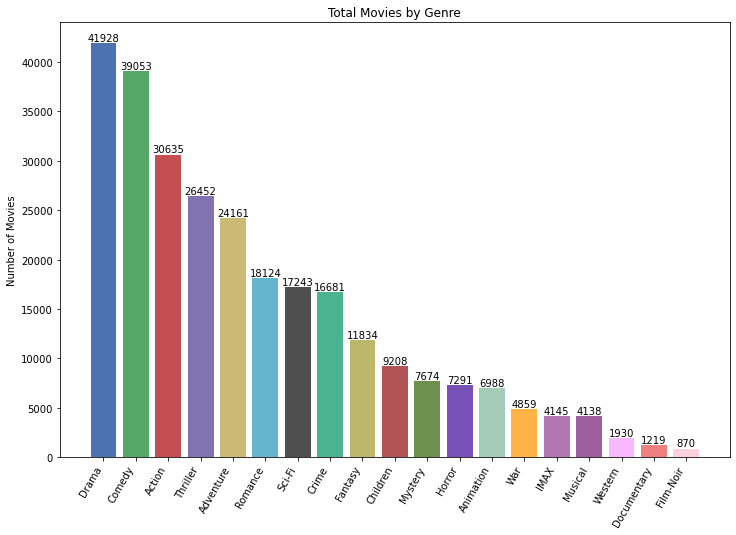

In [26]:
# Create a dictionary to store the total number of movies for each genre
genre_counts = {}
for genre in df.columns[4:23]:#df.columns[4:23] selects all columns with genre information
    genre_counts[genre] = df[genre].sum()

# Sort the genres by popularity
sorted_genres = {k: v for k, v in sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)}

# Plot a bar chart of the total movies by genre
plt.figure(figsize=(12, 8))
bars = plt.bar(x=sorted_genres.keys(), height=sorted_genres.values(), color=['#4C72B0','#55A868','#C44E52','#8172B2','#CCB974','#64B5CD','#4F4F4F','#4CB391','#BDB76B','#B15455','#6D904F','#7851B8','#A5CCB8','#FFB347','#B276B2','#9F5F9F','#F9B7FF','#F08080','#FFD1DC','#F08080'])

# Add labels to the bars with the total number of movies for each genre
for i, bar in enumerate(bars):
    plt.text(x=i, y=bar.get_height(), s=bar.get_height(), ha='center', va='bottom')

# Customize the plot
plt.xticks(rotation=60, ha='right')
plt.ylabel('Number of Movies')
plt.title('Total Movies by Genre')

plt.show()


> For better analysis,the genre column is split and encoded.

In [27]:
# Group the movie_ratings DataFrame by movie title and calculate the average rating
avg_ratings = df.groupby('title')['rating'].mean().sort_values(ascending=False)
avg_ratings

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
                                                ... 
The Beast of Hollow Mountain (1956)              0.5
Follow Me, Boys! (1966)                          0.5
The Butterfly Effect 3: Revelations (2009)       0.5
The Emoji Movie (2017)                           0.5
Rust and Bone (De rouille et d'os) (2012)        0.5
Name: rating, Length: 9719, dtype: float64

In [28]:
# Grouping by the total no. of rating of the movies
rat_count = df.groupby('title')['rating'].count().sort_values(ascending=False)
rat_count

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
                                                                                 ... 
Late Night Shopping (2001)                                                          1
Late Night with Conan O'Brien: The Best of Triumph the Insult Comic Dog (2004)      1
Late Shift, The (1996)                                                              1
Latter Days (2003)                                                                  1
'71 (2014)                                                                          1
Name: rating, Length: 9719, dtype: int64

In [29]:
#Stripping the title to extract the year of release.
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)
df.tail()

,userId,movieId,rating,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed),year
100831,610,160341,2.5,Bloodmoon (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
100832,610,160527,4.5,Sympathy for the Underdog (1971),0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1971
100833,610,160836,3.0,Hazard (2005),0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2005
100834,610,163937,3.5,Blair Witch (2016),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016
100835,610,163981,3.5,31 (2016),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016


In [30]:
# replacing the range with a specific year
df['year'] = df['year'].replace("2006–2007","2007")

In [31]:
df.columns

Index(['userId', 'movieId', 'rating', 'title', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Fantasy', 'Romance', 'Action', 'Crime',
       'Thriller', 'Mystery', 'Horror', 'Drama', 'War', 'Western', 'Sci-Fi',
       'Musical', 'Film-Noir', 'IMAX', 'Documentary', '(no genres listed)',
       'year'],
      dtype='object')

# 6. Exploratory analysis.

## Univariate Analysis

In [32]:
# previewing descriptive statistics of the data set.
df.describe()

,userId,movieId,rating,Adventure,Animation,Children,Comedy,Fantasy,Romance,Action,...,Horror,Drama,War,Western,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed)
count,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,...,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557,0.239607,0.069301,0.091317,0.387292,0.117359,0.179737,0.303810,...,0.072306,0.415804,0.048187,0.019140,0.171000,0.041037,0.008628,0.041106,0.012089,0.000466
std,182.618491,35530.987199,1.042529,0.426846,0.253966,0.288060,0.487134,0.321849,0.383970,0.459904,...,0.258994,0.492862,0.214163,0.137018,0.376511,0.198377,0.092485,0.198537,0.109284,0.021585
min,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,177.000000,1199.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,325.000000,2991.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,477.000000,8122.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,610.000000,193609.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# check merged data set info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userId              100836 non-null  int64  
 1   movieId             100836 non-null  int64  
 2   rating              100836 non-null  float64
 3   title               100836 non-null  object 
 4   Adventure           100836 non-null  int64  
 5   Animation           100836 non-null  int64  
 6   Children            100836 non-null  int64  
 7   Comedy              100836 non-null  int64  
 8   Fantasy             100836 non-null  int64  
 9   Romance             100836 non-null  int64  
 10  Action              100836 non-null  int64  
 11  Crime               100836 non-null  int64  
 12  Thriller            100836 non-null  int64  
 13  Mystery             100836 non-null  int64  
 14  Horror              100836 non-null  int64  
 15  Drama               100836 non-nul

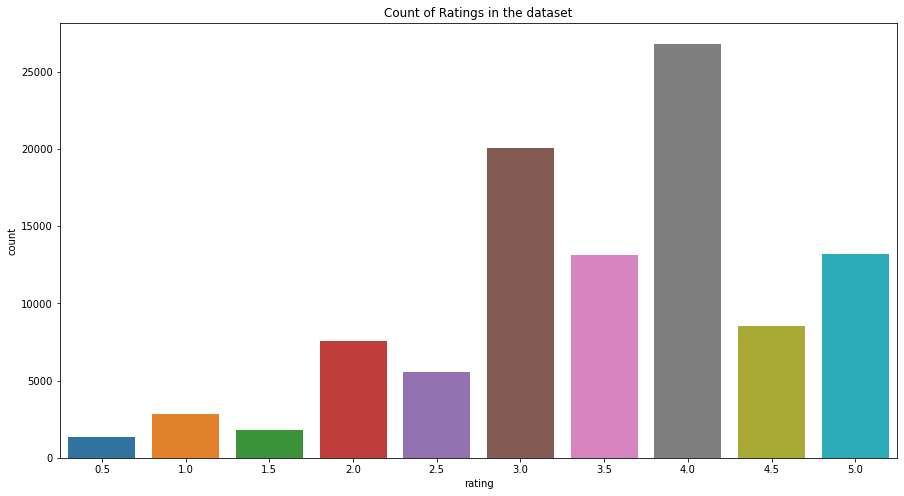

In [34]:
# Distribution of movie ratings.
plt.figure(figsize=(15, 8))
sns.countplot(df['rating'])
plt.title('Count of Ratings in the dataset');

> As seen,the distribution of the rating is not normal.Also,the most number of ratings were in the group of 4.0

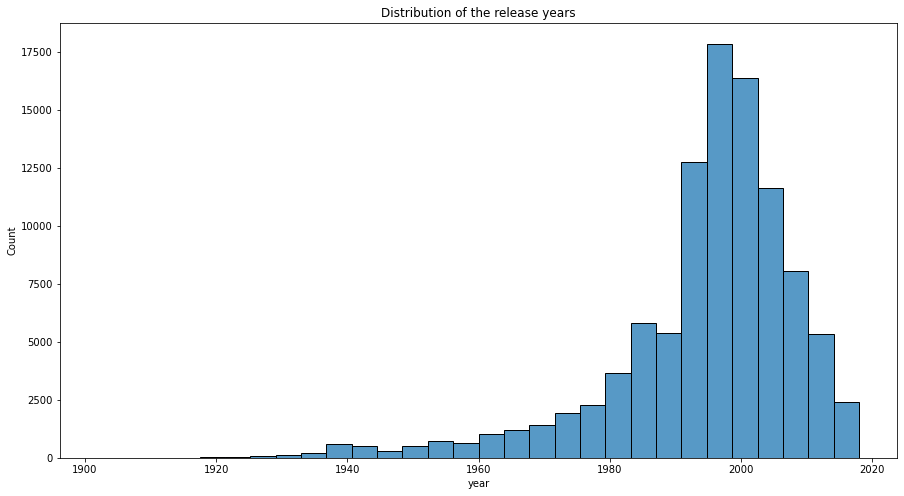

In [35]:
#plot distribution of release years
df['year'] = pd.to_numeric(df['year'])
plt.figure(figsize=(15, 8))
sns.histplot(data=df, x='year', bins=30)
plt.title('Distribution of the release years');


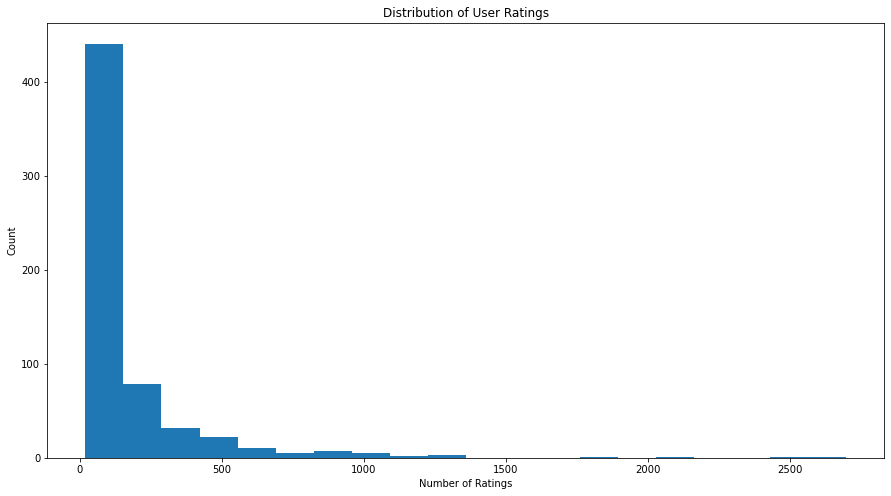

In [36]:
# Group ratings by user ID and count the number of ratings for each user
user_ratings = df.groupby('userId')['rating'].count()

# histogram of number of ratings per user
plt.figure(figsize=(15,8))
plt.hist(user_ratings, bins=20)
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.title('Distribution of User Ratings')
plt.show()

### Bivariate Analysis

In [37]:
period_length = 20
start_year = 1940
end_year = 2019
df = df[(df['year'] >= 1940) & (df['year'] <= 2019)]

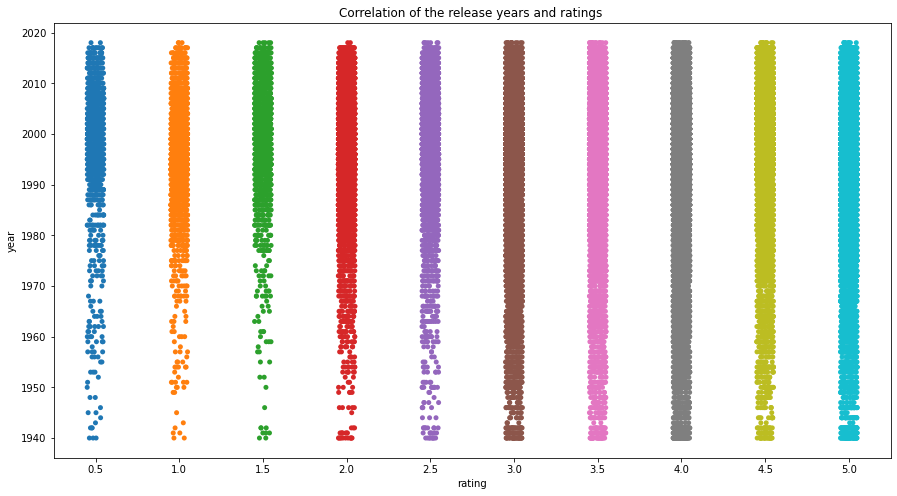

In [38]:
#correlation between rating and year of production
plt.figure(figsize=(15, 8))
plt.title('Correlation of the release years and ratings ')
sns.stripplot(data=df,x='rating',y='year');

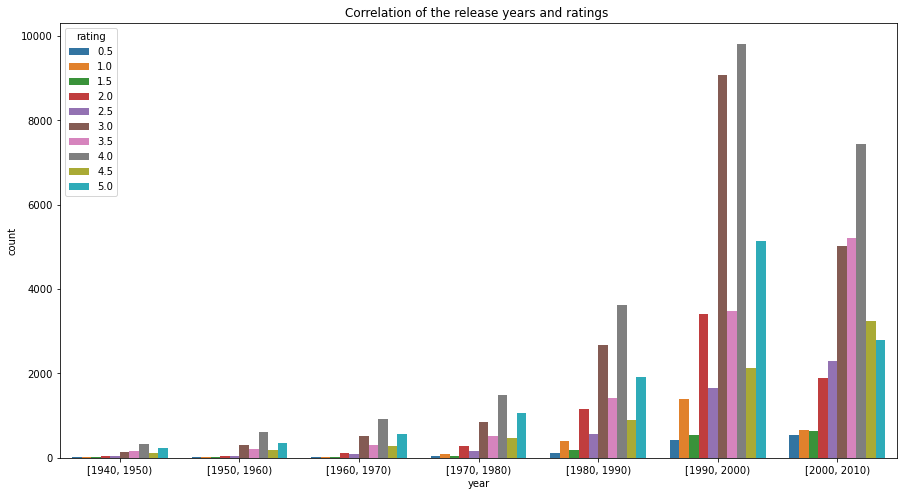

In [39]:
#correlation between year of release and rating
df_extra = df.copy()
df_extra['year'] = pd.cut(df_extra['year'], range(1940, 2019, 10), right=False)
plt.figure(figsize=(15,8))
ax = sns.countplot(data=df_extra, x='year', hue='rating')
plt.title('Correlation of the release years and ratings ')
ax;

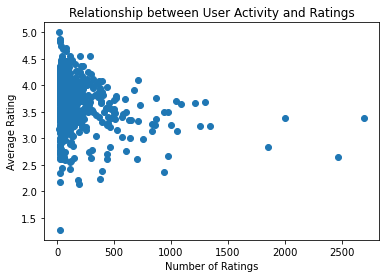

In [40]:
# Calculate average rating and number of ratings per user
user_ratings = df.groupby('userId').agg({'rating': ['mean', 'count']})
user_ratings.columns = ['avg_rating', 'num_ratings']

# Create scatter plot of average rating vs. number of ratings per user
plt.scatter(user_ratings['num_ratings'], user_ratings['avg_rating'])
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.title('Relationship between User Activity and Ratings')
plt.show()


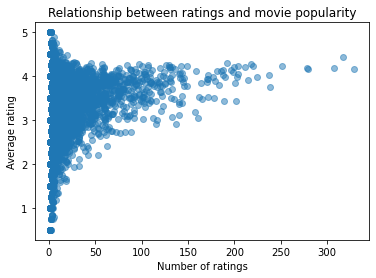

In [41]:
import matplotlib.pyplot as plt

# create a dataframe containing the average rating and number of ratings for each movie
movie_stats = ratings.groupby('movieId').agg({'rating': [np.mean, np.size]})

# flatten the column names and reset the index
movie_stats.columns = movie_stats.columns.get_level_values(1)
movie_stats.reset_index(inplace=True)

# create a scatter plot of average rating vs number of ratings
plt.scatter(x=movie_stats['size'], y=movie_stats['mean'], alpha=0.5)

# set x-axis and y-axis labels
plt.xlabel('Number of ratings')
plt.ylabel('Average rating')

# set title
plt.title('Relationship between ratings and movie popularity')

# show the plot
plt.show()


Add the num_rating and average_rating per movie. The information helps decide the most popular movies.

In [42]:
#get number average rating and number of rating per movie.
mean_rating = df.groupby('movieId').rating.mean().rename('mean rating')
num_rating = df.groupby('movieId').userId.count().rename('num rating')

df = pd.merge(df, mean_rating, how='left', on='movieId')
df = pd.merge(df, num_rating, how='left', on='movieId')


df[['title', 'mean rating', 'num rating']]

,title,mean rating,num rating
0,Toy Story (1995),3.92093,215
1,Toy Story (1995),3.92093,215
2,Toy Story (1995),3.92093,215
3,Toy Story (1995),3.92093,215
4,Toy Story (1995),3.92093,215
...,...,...,...
99986,Bloodmoon (1997),2.50000,1
99987,Sympathy for the Underdog (1971),4.50000,1
99988,Hazard (2005),3.00000,1
99989,Blair Witch (2016),3.50000,1


## Popularity based Recommendation System

The popularity based recommender system will act as the baseline model, helpful for new users. It will recommend to them the 10 top-rated movies.

In [43]:
movie_popularity = df[['title', 'mean rating', 'num rating']]
movie_popularity.tail()

,title,mean rating,num rating
99986,Bloodmoon (1997),2.5,1
99987,Sympathy for the Underdog (1971),4.5,1
99988,Hazard (2005),3.0,1
99989,Blair Witch (2016),3.5,1
99990,31 (2016),3.5,1


In [44]:
movie_popularity.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
2500,Forrest Gump (1994),4.164134,329
2624,Forrest Gump (1994),4.164134,329
2611,Forrest Gump (1994),4.164134,329
2612,Forrest Gump (1994),4.164134,329
2613,Forrest Gump (1994),4.164134,329
2614,Forrest Gump (1994),4.164134,329
2615,Forrest Gump (1994),4.164134,329
2616,Forrest Gump (1994),4.164134,329
2617,Forrest Gump (1994),4.164134,329
2618,Forrest Gump (1994),4.164134,329


It appears that there are multiple entries of the same movie title. These duplicates are dropped below:

In [45]:
movie_popularity = movie_popularity.drop_duplicates(subset=['title'])


In [46]:
movie_popularity.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
2426,Forrest Gump (1994),4.164134,329
16081,"Shawshank Redemption, The (1994)",4.429022,317
1819,Pulp Fiction (1994),4.197068,307
4310,"Silence of the Lambs, The (1991)",4.161290,279
12450,"Matrix, The (1999)",4.192446,278
1568,Star Wars: Episode IV - A New Hope (1977),4.231076,251
3188,Jurassic Park (1993),3.750000,238
854,Braveheart (1995),4.031646,237
26454,Terminator 2: Judgment Day (1991),3.970982,224
3570,Schindler's List (1993),4.225000,220


In [47]:
#most popular movies by mean ratings

movie_popularity.sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
97662,Peaceful Warrior (2006),5.0,1
88215,Rivers and Tides (2001),5.0,1
96127,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",5.0,1
96137,Enter the Void (2009),5.0,2
93400,Madame Sousatzka (1988),5.0,1
96146,Zeitgeist: Moving Forward (2011),5.0,1
96149,Connections (1978),5.0,1
99143,Knock Off (1998),5.0,1
18610,Alien Contamination (1980),5.0,1
18597,Galaxy of Terror (Quest) (1981),5.0,1


Although these movies are popular they only have one rating. Thus, the popularity isnot reliable as it may change as the number of ratings increase.

The threshhold for popularity is set to 150.

In [48]:
popularity_threshold = 150
movie_popularity[movie_popularity['num rating']>popularity_threshold].sort_values(by=['mean rating'], ascending=False).head(10)


,title,mean rating,num rating
16081,"Shawshank Redemption, The (1994)",4.429022,317
45020,"Godfather, The (1972)",4.289062,192
14108,Fight Club (1999),4.272936,218
572,"Usual Suspects, The (1995)",4.237745,204
1568,Star Wars: Episode IV - A New Hope (1977),4.231076,251
3570,Schindler's List (1993),4.225000,220
6659,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211
7012,Raiders of the Lost Ark (Indiana Jones and the...,4.207500,200
1819,Pulp Fiction (1994),4.197068,307
12450,"Matrix, The (1999)",4.192446,278


The above movies are not only popular but also loved by the users. 

The scatter plot below examines whether there's a correlation between number of ratings and average ratings. It shows whether movies that are highly rated are indeed watched by more people.

Text(0.5, 1.0, 'Relationship between Mean Rating and Number of Ratings per Movie')

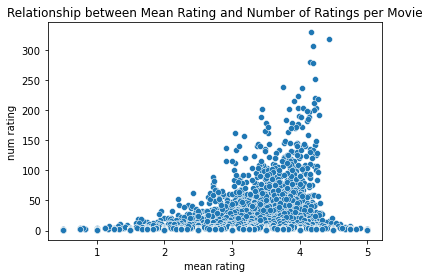

In [49]:
#scatterplot of mean rating and number of ratings
sns.scatterplot(data=movie_popularity, x='mean rating', y ='num rating')
plt.title('Relationship between Mean Rating and Number of Ratings per Movie')
#plt.savefig('Images/mean_num_rating')


The scatterplot shows that there is indeed a positive relationship between number of ratings and the mean rating. 

Mobies that are highly rated are watched by more people. Probably because they are a good watch.

A new user maybe specific and search for a very specific genre, say drama.

In [50]:
#check users who are interested in drama
user_genre ='Drama'
movie_popularity[df[user_genre] == 1].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
97121,"Thousand Clowns, A (1965)",5.0,1
95587,Come and See (Idi i smotri) (1985),5.0,2
87942,Front of the Class (2008),5.0,1
92581,"Son of the Bride (Hijo de la novia, El) (2001)",5.0,1
96137,Enter the Void (2009),5.0,2
87913,Sisters (Syostry) (2001),5.0,1
95596,Che: Part One (2008),5.0,1
98412,Lady Jane (1986),5.0,1
96127,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",5.0,1
96493,King of Hearts (1966),5.0,1


Set a popularity threshold just like above.

In [51]:
# Set the genre of interest
user_genre = 'Drama'

# Set the minimum number of ratings required for a movie to be considered popular
popularity_threshold = 150

# Select the top 10 highest rated movies in the specified genre that meet the popularity threshold
movie_popularity[(df[user_genre] == 1) & (df['num rating']>popularity_threshold)].sort_values(by=['mean rating'], ascending=False).head(10)


,title,mean rating,num rating
16081,"Shawshank Redemption, The (1994)",4.429022,317
45020,"Godfather, The (1972)",4.289062,192
14108,Fight Club (1999),4.272936,218
3570,Schindler's List (1993),4.225000,220
1819,Pulp Fiction (1994),4.197068,307
2426,Forrest Gump (1994),4.164134,329
10611,Saving Private Ryan (1998),4.146277,188
37607,"Lord of the Rings: The Return of the King, The...",4.118919,185
4649,Fargo (1996),4.116022,181
13637,American Beauty (1999),4.056373,204


## Final Baseline Model(New User) 

The final baseline model for new users combines all the above:
* If no information is provided, the user is recommended the popular movies rated than 150 times(which have been rated at least 150 times).
* If the user presents a threshold, say, top 10, then the user gets the top 10 movies with highest ratings.
* If the user presents a genre, then the user is recommended top-rated movies from that genre. 

In [52]:
import ipywidgets as widgets
from IPython.display import display

# Function to recommend movies based on a given threshold and favorite genre
def baseline_model(threshold, fav_genre):
    minimum_num_ratings = threshold
    if fav_genre == 'All':
        result = movie_popularity[(df['num rating'] > minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)
    else:
        result = movie_popularity[(df[fav_genre] == 1) & (df['num rating'] > minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

    print('\n\nThese are the recommendations for the users with the following filters')
    print('Minimum number of ratings:', threshold)
    print("User's choice of genre:", fav_genre)
    display(result)

# List of genres to be used in the interactive widget
genres = ['All',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir']

# Interactive widget for users to select their preferred genre and minimum number of ratings
w = widgets.interactive(baseline_model, threshold=widgets.IntSlider(min=0, max=200, value=100, step=5),
                       fav_genre=widgets.Dropdown(options=genres, description="Genre"))
display(w)


interactive(children=(IntSlider(value=100, description='threshold', max=200, step=5), Dropdown(description='Ge…

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
# Split the data into training and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [55]:
from scipy.linalg import svd

In [56]:
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader
# Define the format of the dataframe
reader = Reader(rating_scale=(0.5, 5.0))
# Convert your dataframe to a Surprise dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)
# Define the SVD algorithm
algo = SVD()
# Train the algorithm on the training set
algo.fit(trainset)
# Test the algorithm on the testing set
predictions = algo.test(testset)
# Calculate and print the accuracy metrics
accuracy.rmse(predictions)
accuracy.mae(predictions)
# Use the trained algorithm to make a prediction
uid = str(196)  # user ID
iid = str(302)  # item ID
pred = algo.predict(uid, iid)
print('Predicted rating:', pred.est)

RMSE: 0.8692
MAE:  0.6707
Predicted rating: 3.4986265384769246


In [57]:
from surprise.prediction_algorithms import knns

In [58]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [59]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed),year,mean rating,num rating,totalRatingCount
0,1,1,4.0,Toy Story (1995),1,1,1,1,1,0,...,0,0,0,0,0,0,1995.0,3.92093,215,215
1,5,1,4.0,Toy Story (1995),1,1,1,1,1,0,...,0,0,0,0,0,0,1995.0,3.92093,215,215
2,7,1,4.5,Toy Story (1995),1,1,1,1,1,0,...,0,0,0,0,0,0,1995.0,3.92093,215,215
3,15,1,2.5,Toy Story (1995),1,1,1,1,1,0,...,0,0,0,0,0,0,1995.0,3.92093,215,215
4,17,1,4.5,Toy Story (1995),1,1,1,1,1,0,...,0,0,0,0,0,0,1995.0,3.92093,215,215


In [60]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   9526.000
mean      10.497
std       22.572
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRatingCount, dtype: float64


In [61]:
popularity_threshold = 250
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

,userId,movieId,rating,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Sci-Fi,Musical,Film-Noir,IMAX,Documentary,(no genres listed),year,mean rating,num rating,totalRatingCount
1568,1,260,5.000,Star Wars: Episode IV - A New Hope (1977),1,0,0,0,0,0,...,1,0,0,0,0,0,1977.000,4.231,251,251
1569,4,260,5.000,Star Wars: Episode IV - A New Hope (1977),1,0,0,0,0,0,...,1,0,0,0,0,0,1977.000,4.231,251,251
1570,7,260,5.000,Star Wars: Episode IV - A New Hope (1977),1,0,0,0,0,0,...,1,0,0,0,0,0,1977.000,4.231,251,251
1571,15,260,5.000,Star Wars: Episode IV - A New Hope (1977),1,0,0,0,0,0,...,1,0,0,0,0,0,1977.000,4.231,251,251
1572,16,260,3.000,Star Wars: Episode IV - A New Hope (1977),1,0,0,0,0,0,...,1,0,0,0,0,0,1977.000,4.231,251,251


In [62]:
# create pivot table
movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
# print head of pivot table
movie_features_df.head()


userId,1,2,4,5,6,7,8,10,11,13,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Forrest Gump (1994),4.000,0.000,0.000,0.000,5.000,5.000,3.000,3.500,5.000,0.000,...,0.000,3.000,3.000,0.000,3.000,4.000,0.000,3.000,4.000,3.000
"Matrix, The (1999)",5.000,0.000,1.000,0.000,0.000,0.000,0.000,0.500,0.000,5.000,...,5.000,0.000,5.000,0.000,0.000,5.000,5.000,5.000,0.000,5.000
Pulp Fiction (1994),3.000,0.000,1.000,5.000,2.000,0.000,4.000,1.000,0.000,0.000,...,0.000,5.000,5.000,5.000,2.000,5.000,3.000,5.000,4.000,5.000
"Shawshank Redemption, The (1994)",0.000,3.000,0.000,3.000,5.000,0.000,5.000,0.000,4.000,0.000,...,5.000,5.000,0.000,0.000,0.000,3.500,5.000,4.500,4.000,3.000
"Silence of the Lambs, The (1991)",4.000,0.000,5.000,0.000,4.000,5.000,4.000,0.000,5.000,0.000,...,0.000,5.000,5.000,5.000,0.000,4.500,5.000,4.000,0.000,4.500


# KNN MODEL

In [65]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

1


In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Matrix, The (1999):

1: Star Wars: Episode IV - A New Hope (1977), with distance of 0.3365532537559339:
2: Forrest Gump (1994), with distance of 0.39006520118223087:
3: Pulp Fiction (1994), with distance of 0.3963550577522702:
4: Shawshank Redemption, The (1994), with distance of 0.4108450453763719:
5: Silence of the Lambs, The (1991), with distance of 0.44103422527334946:


In [67]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Load data
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN model
k = 5 # Number of neighbors to consider
model = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine')
model.fit(X_train)

# Evaluate model on test set
test_scores = []
for i, x_test in enumerate(X_test):
    # Find the k nearest neighbors to the test sample
    distances, indices = model.kneighbors(x_test.reshape(1, -1))
    
    # Predict rating as the weighted average of the neighbors' ratings
    numerator = 0
    denominator = 0
    for j in range(k):
        neighbor_idx = indices[0][j]
        similarity = 1 - distances[0][j]
        rating = y_train[neighbor_idx]
        numerator += similarity * rating
        denominator += similarity
    if denominator != 0:
        predicted_rating = numerator / denominator
    else:
        predicted_rating = 0
    
    # Compute test score as the mean absolute error between predicted and true rating
    true_rating = y_test[i]
    test_score = np.abs(predicted_rating - true_rating)
    test_scores.append(test_score)
    
mean_absolute_error = np.mean(test_scores)
print('Mean absolute error on test set:', mean_absolute_error)


ValueError: could not convert string to float: 'Catwoman (2004)'